In [1]:
import pandas as pd
import numpy as np
from collections import Counter
pd.options.display.max_rows=100

In [2]:
all_labels = pd.read_pickle('/home/prateekagarw_umass_edu/p_file/all_labels')
all_labels

,image_name,adjective_1,adjective_2,negative_adj,object_1,object_2
0,p_0.jpg,bigger,smaller,"[bluer, hairier]",dogs,
1,p_1.jpg,cleaner,dirtier,[bigger],hands,
2,p_2.jpg,hairier,balder,"[longer, thicker]",cats,
3,p_3.jpg,younger,older,"[denser, cleaner]",persons,
4,p_5.jpg,colder,hotter,"[fuller, curvier]",drinks,
...,...,...,...,...,...,...
252,k_60.jpg,fatter,skinnier,"[narrower, fancier, taller]",people,
253,k_61.jpg,nearer,farther,"[heavier, bluer, smoother]",objects,
254,k_62.jpg,shinier,duller,"[heavier, curvier, curlier]",piggybank,santa
255,k_63.jpg,fatter,skinnier,"[drier, broader, blacker]",fishes,


In [3]:
#Modeling 
import pandas as pd
import os
import glob
import numpy as np
import time
import requests
import random
import matplotlib.pyplot as plt
from PIL import Image
import requests
import torch
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel
model_name = "openai/clip-vit-base-patch32"
# model_name = "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

In [4]:
#Load Adjectives (No None)
adjectives_list = all_labels['adjective_1'].tolist()
#Load Antonyms (Does have None)
antonyms_list = all_labels['adjective_2'].tolist()
#Unique Adjectives
adjectives = Counter(adjectives_list)
# adjectives.update(antonyms_list)
unique_adjectives = list(adjectives.keys())
# unique_adjectives.remove("None")
print(len(unique_adjectives))
print(unique_adjectives)

39
['bigger', 'cleaner', 'hairier', 'younger', 'colder', 'taller', 'harder', 'drier', 'nearer', 'fatter', 'curlier', 'riper', 'blacker', 'heavier', 'sharper', 'newer', 'fuller', 'shinier', 'smoother', 'rustier', 'darker', 'coarser', 'longer', 'fresher', 'flatter', 'narrower', 'thicker', 'higher', 'brighter', 'fewer', 'flakier', 'clearer', 'curvier', 'deeper', 'bluer', 'denser', 'fancier', 'sunnier', 'broader']


In [5]:
#make a list of prompts
groundtruth_labels = [ ]
scores = [ ]
adj_prompts_list = [f'The objects in this image can be compared using the adjective "{k}"' for k in unique_adjectives]
accuracy = 0
predicted_indices = []

for idx,row in all_labels.iterrows():
    
  img_name, adjective, antonym = row['image_name'],row['adjective_1'],row['adjective_2']

  img_path = "/home/prateekagarw_umass_edu/p_file/all_aug/" + img_name
  img = Image.open(img_path)

  groundtruth_labels.append(unique_adjectives.index(adjective))
  
  inputs = processor(text=adj_prompts_list, images=img, return_tensors="pt", padding=True).to(device)
  outputs = model(**inputs).logits_per_image
  probs = outputs.softmax(dim=1) 
  scores.append(probs.cpu().detach().numpy())
  # prob, idxs = probs[0].topk(39)
  # top_adj_prompts = [unique_adjectives[i] for i in idxs[:k]]
  # print("groundtruth adjective is "+ adjective + " and its antonym is " + antonym)
  # predicted_index = top_adj_prompts.index(correct_adjective)
  # avg_index += predicted_index
  # predicted_indices.append(predicted_index)
  # print(top_adj_prompts)
  # plt.figure(figsize=(8, 10))
  # plt.imshow(np.asarray(img))
  # plt.show()
 
#   if antonym!="None" and antonym in top_adj_prompts:
#     accuracy+=1
#   if adjective in top_adj_prompts:
#     accuracy+=1
#   else:
#     continue
# print(accuracy/len(img_name_list))
# print(avg_index/len(sided_df["adjective"]))

In [18]:
#Analyze number of times a negative is behind a positive word
total_count = 0
indices = [ ]
differences = [ ]
wrong_adjectives = []
for idx,row in all_labels.iterrows():
    negatives = row['negative_adj']
    positive = row['adjective_1']
    score = scores[idx][0,:]
    negative_scores = [score[unique_adjectives.index(n)] for n in negatives]
    positive_score = score[unique_adjectives.index(positive)]
    cur_count = 0 
    negative = [ ]
    for elem in negative_scores:
        if elem>positive_score:
            cur_count+=1
            differences.append(elem-positive_score)
            negative.append(negatives[negative_scores.index(elem)])
            print(row['image_name'], positive, negative)
    if cur_count>0:
        total_count+=1
        wrong_adjectives.append(positive)
    
print(total_count/257)

p_0.jpg bigger ['hairier']
p_9.jpg nearer ['higher']
p_16.jpg blacker ['hairier']
p_17.jpg heavier ['younger']
p_23.jpg fuller ['bigger']
p_23.jpg fuller ['bigger', 'flatter']
p_27.jpg shinier ['heavier']
p_29.jpg smoother ['riper']
p_30.jpg rustier ['narrower']
p_30.jpg rustier ['narrower', 'heavier']
p_33.jpg drier ['sunnier']
p_34.jpg coarser ['drier']
p_37.jpg fuller ['narrower']
p_37.jpg fuller ['narrower', 'brighter']
p_38.jpg longer ['shinier']
p_38.jpg longer ['shinier', 'thicker']
p_39.jpg bigger ['riper']
p_44.jpg nearer ['riper']
p_45.jpg flatter ['curlier']
p_46.jpg flatter ['fancier']
p_47.jpg flatter ['smoother']
p_49.jpg narrower ['hairier']
p_50.jpg narrower ['bluer']
p_51.jpg thicker ['newer']
p_52.jpg hairier ['riper']
p_56.jpg higher ['curvier']
p_56.jpg higher ['curvier', 'cleaner']
p_59.jpg sharper ['riper']
p_63.jpg rustier ['heavier']
p_63.jpg rustier ['heavier', 'sharper']
p_65.jpg blacker ['newer']
p_69.jpg smoother ['coarser']
p_69.jpg smoother ['coarser', 'fl

Counter({'nearer': 11, 'bigger': 9, 'fuller': 7, 'flatter': 7, 'darker': 7, 'blacker': 6, 'heavier': 6, 'smoother': 6, 'narrower': 6, 'thicker': 5, 'rustier': 4, 'drier': 4, 'longer': 4, 'cleaner': 4, 'broader': 4, 'higher': 3, 'sharper': 3, 'harder': 3, 'clearer': 3, 'deeper': 3, 'denser': 3, 'shinier': 2, 'fewer': 2, 'taller': 2, 'coarser': 1, 'hairier': 1, 'curvier': 1, 'flakier': 1, 'younger': 1, 'curlier': 1, 'newer': 1, 'sunnier': 1, 'fresher': 1, 'fatter': 1, 'colder': 1, 'fancier': 1, 'bluer': 1})


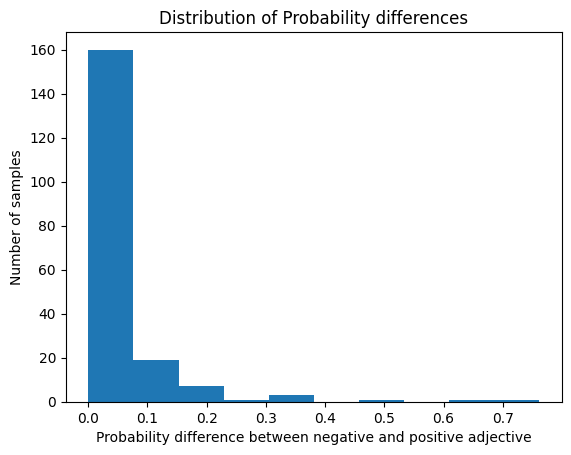

In [17]:
print(Counter(wrong_adjectives))
plt.hist(differences)
plt.xlabel('Probability difference between negative and positive adjective')
plt.ylabel('Number of samples')
plt.title('Distribution of Probability differences')
plt.savefig('histofnegatives.png', dpi=300)
plt.show()


1 0.22568093385214008
3 0.39299610894941633
5 0.4669260700389105
10 0.5992217898832685
15 0.7315175097276264
20 0.8210116731517509
25 0.8638132295719845
30 0.9299610894941635
35 0.9883268482490273


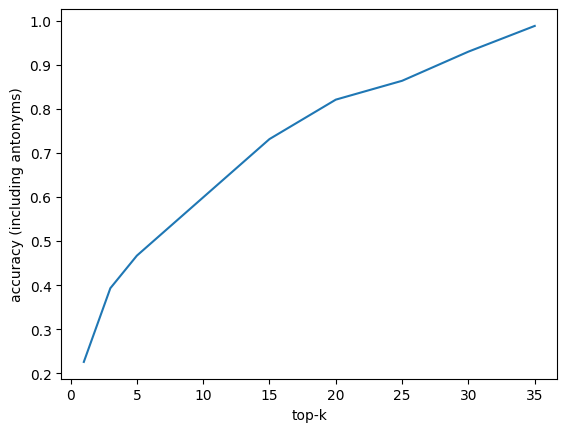

In [8]:
scores_np = np.asarray(scores).squeeze(1)
from sklearn.metrics import top_k_accuracy_score
k_s = [1,3,5,10,15,20,25,30,35]
k_scores = [ ]
for k in k_s:
  k_score = top_k_accuracy_score(np.array(groundtruth_labels),np.asarray(scores).squeeze(1),k = k)
  print(str(k) +" "+ str(k_score))
  k_scores.append(k_score)

plt.plot(k_s,k_scores)
plt.xlabel("top-k")
plt.ylabel("accuracy (including antonyms)")
plt.show()